## Introduction:
The goal of this project is to establish a robust intelligent system to aid in value investing efforts using stock market data. The system will help make investment decisions and based on intrinsic value of companies. It will not, however, trade on the basis of daily market volatility. This project is a part 3 of a series of 7 companies. At the end of the project we will be able to:


1.   Predict stock price valuations on a daily, weekly and monthly basis
2.   Recommend to buy, sell or hold based on certain decision parameters
3.   Maximize capital returns, minimise loses, and minise hold periods

## Loading Libraries And Data For Turkey Koc Holding AS (KCHOL)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss

In [ ]:
df = pd.read_excel('/content/2020Q1Q2Q3Q4-2021Q1.xlsx', sheet_name='Turkey - Koc Holding AS (KCHOL)')

## Data Wrangling

In [ ]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,19.41,19.42,19.63,19.27,13.14M,-0.0046
1,2021-03-30 00:00:00,19.5,19.12,19.81,19.03,21.05M,0.0209
2,2021-03-29 00:00:00,19.1,19.24,19.67,19.1,16.56M,-0.0078
3,2021-03-26 00:00:00,19.25,20.28,20.36,19.1,21.35M,-0.0385
4,2021-03-25 00:00:00,20.02,20.5,20.86,20.02,15.93M,-0.0148


In [ ]:
df.shape

(316, 7)

In [ ]:
df.isna().any()

Date        False
Price       False
Open        False
High        False
Low         False
Vol.         True
Change %     True
dtype: bool

In [ ]:
df.dtypes

Date         object
Price        object
Open         object
High         object
Low          object
Vol.         object
Change %    float64
dtype: object

In [ ]:
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
311,2020-01-07 00:00:00,19.93,20.22,20.28,19.92,2.89M,-0.0075
312,2020-01-06 00:00:00,20.08,20.34,20.34,19.97,1.94M,-0.0108
313,2020-01-03 00:00:00,20.3,20.3,20.44,19.97,3.31M,-0.0039
314,2020-01-02 00:00:00,20.38,20.42,20.44,20.24,2.53M,0.0030
315,Highest: 25.48,Lowest: 12.38,Difference: 13.10,Average: 17.86,Change %: -4.48,NaN,NaN


In [ ]:
df = df[:-1]

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [ ]:
def remove_string(data, column, item):
  data[column] = df[column].str.replace(item, '').astype(float)
  return data[column].dtype

In [ ]:
remove_string(df, 'Vol.', 'M')

dtype('float64')

In [ ]:
for i in df.columns:
  df[i] = df[i].astype(float)

In [ ]:
df.isna().any()

Price       False
Open        False
High        False
Low         False
Vol.        False
Change %    False
dtype: bool

## Exploratory Data Analysis

In [ ]:
y = df['Price']

In [ ]:
y.describe()

count    315.000000
mean      17.857397
std        2.891400
min       12.790000
25%       15.010000
50%       17.580000
75%       20.130000
max       24.080000
Name: Price, dtype: float64

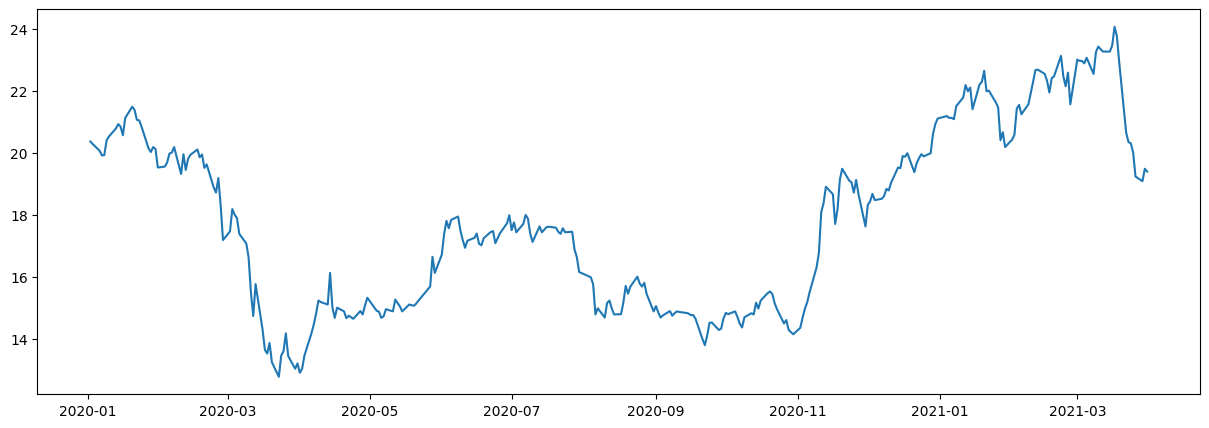

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(y)
plt.show()

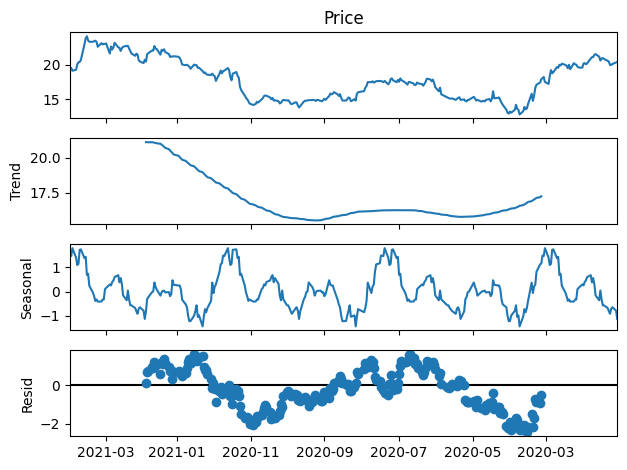

In [ ]:
decomp = seasonal_decompose(y, model='additive', period=90)
decomp.plot()
plt.show()

# Stationarity Check

In [ ]:
kpss_stat, p_value, n_lags, critical_values = kpss(y)
def stationarity_check(value):
  if value < 0.05:
    print(f'Data is Stationary')
  else:
    print(f'Data is Non-Stationary')
stationarity_check(p_value)

Data is Stationary


In [ ]:
df['rolling_mean'] = df['Price'].rolling(window=5).mean()
df.dropna(inplace=True)

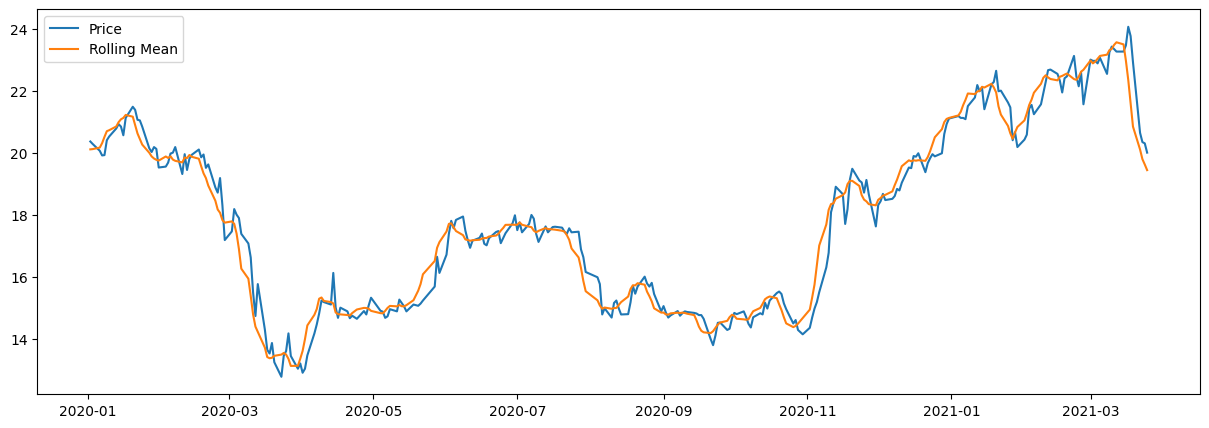

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df['Price'], label='Price')
plt.plot(df['rolling_mean'], label='Rolling Mean')
plt.legend()
plt.show()

In [ ]:
stationarity_check(kpss(df['rolling_mean'])[1])

Data is Stationary


In [ ]:
df_train = df.loc['2020-01-01':'2021-01-01']
df_test = df.loc['2021-01-01':]

## Creating The ARIMA Forecasting Model

In [ ]:
def evaluate_arima_model(data, arima_order):
  train, test = df_train['rolling_mean'].values, df_test['rolling_mean'].values
  past = [x for x in train]
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(past, order=arima_order)
    model_fit = model.fit()
    future = model_fit.forecast()[0]
    predictions.append(future)
    past.append(test[t])
  error = mean_squared_error(test, predictions)
  return error

## Finding The Best ARIMA Order For The Model

In [ ]:
def evaluate_models(data, p_values, d_values, q_values):
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p, q, d)
        try:
          mse = evaluate_arima_model(data, order)
          if mse < best_score:
            best_score, best_cfg = mse, order
          print('ARIMA%s MSE=%.3f' % (order, mse))
        except:
          continue
  return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [ ]:
#evaluate_arima_model(df, (1, 0, 1))

In [ ]:
#evaluate_models(df, p_values, d_values, q_values)

In [ ]:
p = 2
d = 0
q = 0
model = ARIMA(df_train['rolling_mean'], order=(p, d, q))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           rolling_mean   No. Observations:                  252
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 208.356
Date:                Fri, 22 Dec 2023   AIC                           -408.712
Time:                        03:06:08   BIC                           -394.594
Sample:                             0   HQIC                          -403.031
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.5122      0.939     18.655      0.000      15.672      19.352
ar.L1          1.8353      0.031     59.696      0.000       1.775       1.896
ar.L2         -0.8412      0.030    -27.750      0.000      -0.901      -0.782
sigma2         0.0109      0.001     12.359      0.000       0.009       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):                 5.12
Prob(Q):                              0.52   Prob(JB):                         0.08
Heteroskedasticity (H):               2.08   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Plotting The Fitted ARIMA Model

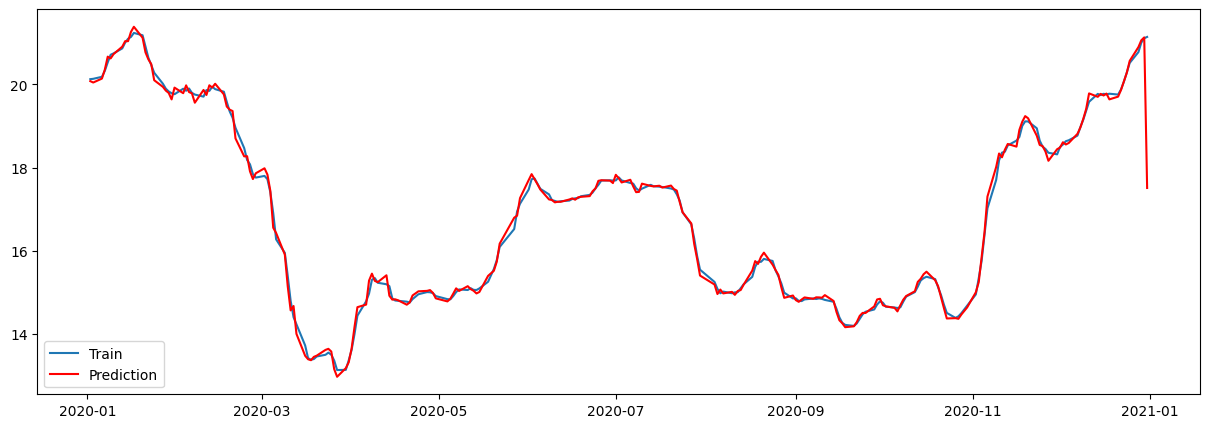

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df_train['rolling_mean'], label='Train')
plt.plot(model_fit.predict(), color='red', label='Prediction')
plt.legend()
plt.show()

# Plotting Forecasts

In [ ]:
future_cast = model_fit.forecast(len(df_test))

In [ ]:
future_cast.index = df_test.index

In [ ]:
future_cast = pd.DataFrame(future_cast)

In [ ]:
future_cast.columns = ['rolling_mean']

In [ ]:
future_cast.head()

,rolling_mean
Date,
2021-03-25,20.103810
2021-03-24,20.069814
2021-03-23,20.026088
2021-03-22,19.974434
2021-03-19,19.916418


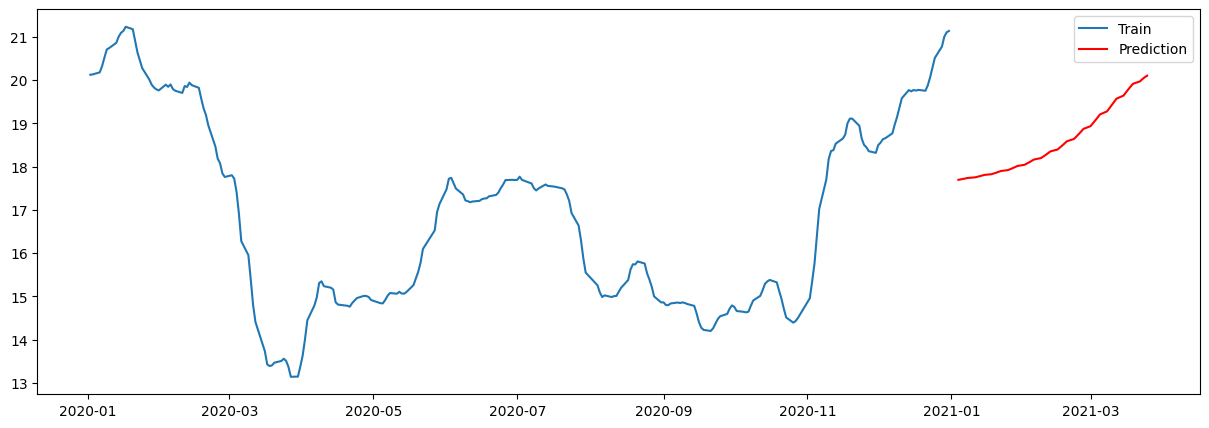

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df_train['rolling_mean'], label='Train')
plt.plot(future_cast['rolling_mean'], color='red', label='Prediction')
plt.legend()
plt.show()

In [ ]:
def evaluate_arima_model(data, arima_order, start_train_size):
    history = list(data[:start_train_size])
    predictions = []
    for t in range(start_train_size, len(data)):

        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast(7)[-1]
        predictions.append(future)
        history.append(data[t])
    mse = mean_squared_error(data[start_train_size:], predictions)
    mpe = mean_absolute_percentage_error(data[start_train_size:], predictions)

    return mse , mpe, predictions

In [ ]:
mse, mpe, predictions = evaluate_arima_model(df['rolling_mean'].sort_index(), (2, 0, 0), len(df_train))

In [ ]:
forecast = pd.DataFrame(predictions)
forecast.columns = ['rolling_mean']
forecast.index = df_test.index[::-1]
forecast.head()

,rolling_mean
Date,
2021-01-04,20.821299
2021-01-05,21.085605
2021-01-06,21.357187
2021-01-07,21.883202
2021-01-08,21.933279


In [ ]:
f_std = forecast['rolling_mean'].std()

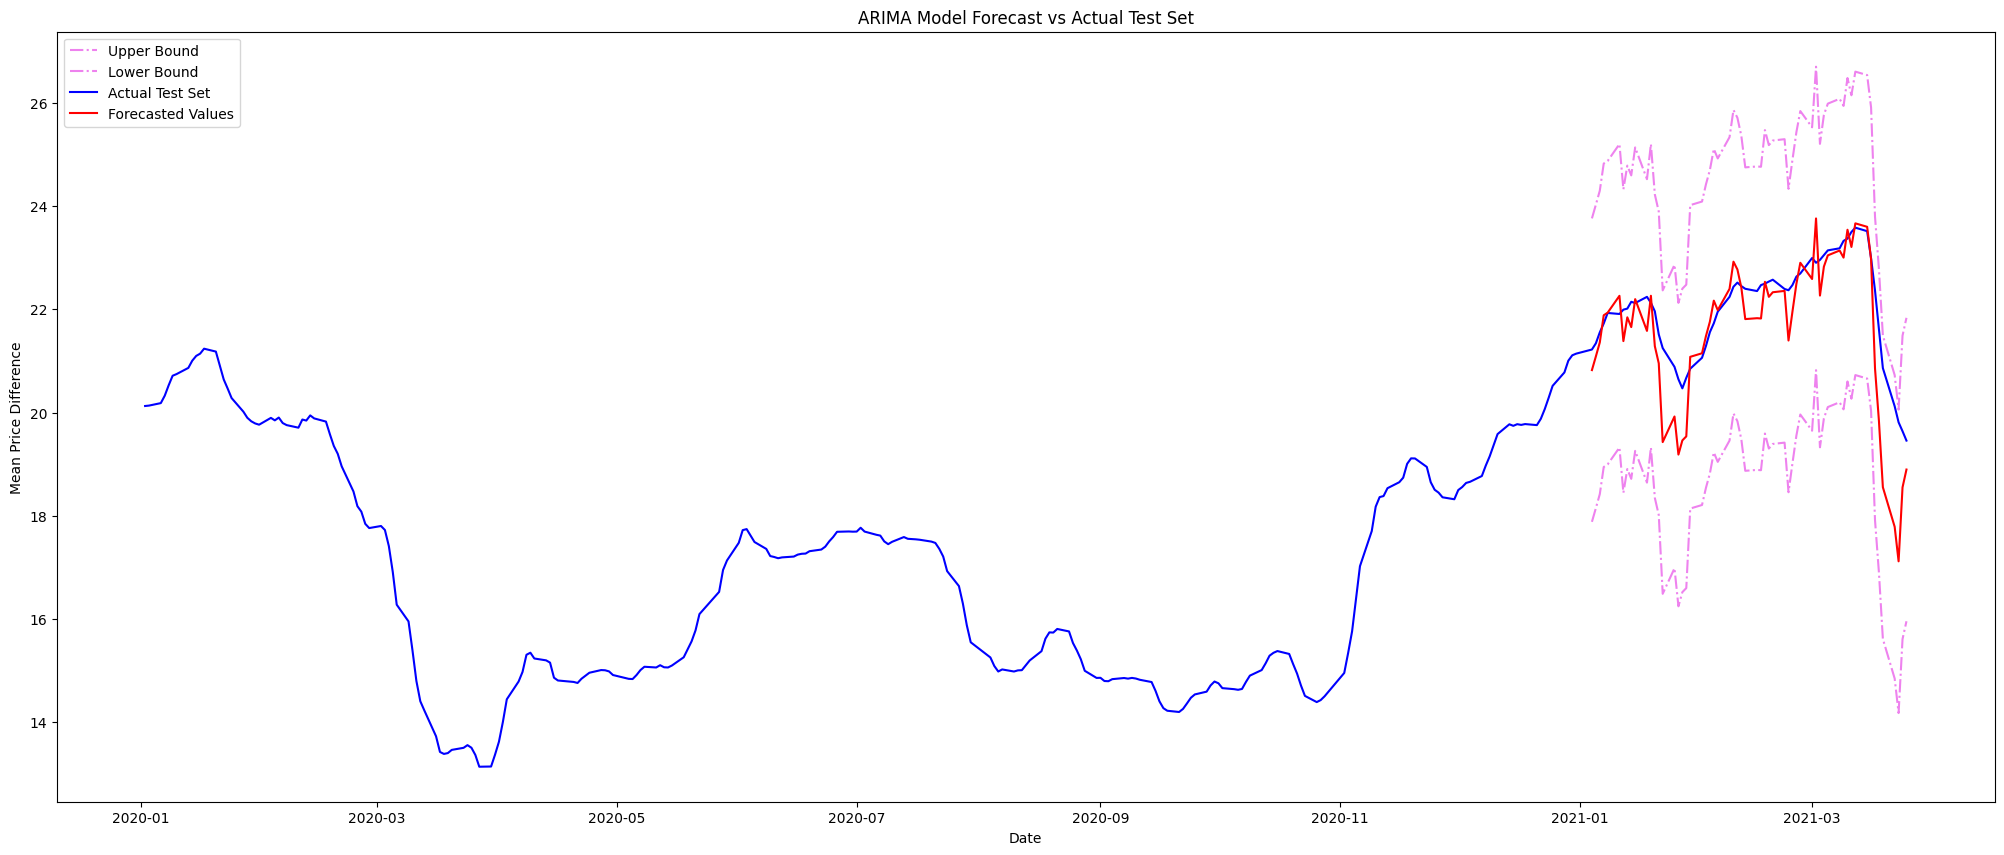

In [ ]:
plt.figure(figsize=(25,10))
plt.plot(forecast['rolling_mean'] + 1.96*f_std, label='Upper Bound', color='violet', linestyle='-.')
plt.plot(forecast['rolling_mean'] - 1.96*f_std, label='Lower Bound', color='violet', linestyle='-.')

plt.plot(df['rolling_mean'], label='Actual Test Set', color='blue')

plt.plot(forecast, label='Forecasted Values', color='red')

plt.title('ARIMA Model Forecast vs Actual Test Set')
plt.xlabel('Date')
plt.ylabel('Mean Price Difference')
plt.legend()
plt.show()

In [ ]:
o_std = df['rolling_mean'].std()

## Decisions: Buy, Sell, or Hold?

In [ ]:
def buy_sell_hold(forecast, look_ahead, data, threshold=1.96):
  standard_dev = data['rolling_mean'].std()
  decisions = []
  open_prices = []
  dates = []
  buy_sell_flag = 'buy'
  for i in range(len(forecast) - look_ahead):
    if standard_dev is None:
      return "Please provide standard deviation"
    else:
      open_prices.append(data['Open'].iloc[i])
      dates.append(forecast.index[i])
      if (forecast.iloc[i + look_ahead] > forecast.iloc[i] + threshold * standard_dev) & (buy_sell_flag != 'buy'):
        decisions.append('buy')
        buy_sell_flag = 'buy'
      elif (forecast.iloc[i + look_ahead] < forecast.iloc[i] - threshold * standard_dev) & (buy_sell_flag != 'sell'):
        decisions.append('sell')
        buy_sell_flag = 'sell'
      else:
        decisions.append('hold')
  df = pd.DataFrame({'Decision': decisions, 'Open': open_prices}, index=dates)
  return df

In [ ]:
decision_df = buy_sell_hold(forecast['rolling_mean'], look_ahead=7, data=df, threshold=0.1)

## Assessing Profit Based On Decision

In [ ]:
def decision_score(lst):
  score = 0
  for i in range(len(lst)):
    if lst[i] == 'buy':
      score += 1
    elif lst[i] == 'sell':
      score -= 1
    else:
      score += 0
  return score

In [ ]:
decision_score(decision_df['Decision'])

-1